In [1]:
import pandas as pd
from math import cos, radians, sqrt
from sklearn.neighbors import BallTree
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point
import numpy as np
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import binomtest
from tqdm import tqdm

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.3f}'.format)
warnings.filterwarnings('ignore')

In [3]:
raw = "C:\\Users\\Taavi\\Desktop\\BPhil\\Raw data\\"
clean = "C:\\Users\\Taavi\\Desktop\\BPhil\\Clean data\\"

In [4]:
demos = pd.read_csv(clean + 'clean_demos.csv')
demos = demos.loc[demos['status'] == 'Completed']

In [5]:
parcels = pd.read_csv(clean + 'blight.csv')

In [7]:
fig = px.scatter_mapbox(demos, lat = 'lat', lon = 'lng', zoom = 10)
fig.update_layout(mapbox_style = 'open-street-map')
fig.show()

In [6]:
merged = parcels.merge(right = demos.assign(demo = 1)[['parcelID', 'demo']], on = 'parcelID', how = 'left').fillna(0)

In [9]:
merged['demo'].mean()

np.float64(0.005039811735958293)

In [10]:
merged.groupby('blight')['demo'].mean()

blight
1   0.002
2   0.005
3   0.004
4   0.007
5   0.012
6   0.008
7   0.008
Name: demo, dtype: float64

In [11]:
merged['blight'].value_counts(normalize = True)

blight
1   0.331
2   0.317
4   0.194
5   0.067
3   0.062
6   0.023
7   0.006
Name: proportion, dtype: float64

In [12]:
merged.groupby('demo')['blight'].value_counts(normalize = True)

demo   blight
0.000  1        0.332
       2        0.317
       4        0.193
       5        0.067
       3        0.062
       6        0.023
       7        0.006
1.000  2        0.329
       4        0.281
       5        0.157
       1        0.143
       3        0.045
       6        0.034
       7        0.010
Name: proportion, dtype: float64

In [13]:
results = []

prop_pop = merged['demo'].mean()

for group, gdf in merged.groupby('blight'):
    n = len(gdf)
    k = int(gdf['demo'].sum())
    prop_group = k / n

    # z-test
    z_t, z_p = proportions_ztest(k, n, prop_pop)

    # binomial test
    bin_p = binomtest(k, n, prop_pop).pvalue

    results.append({
        'group': group,
        'n': n,
        'prop_pop': prop_pop,
        'prop_group': prop_group,
        'z_p': z_p,
        'bin_p': bin_p
    })

results = pd.DataFrame(results)

In [14]:
results

,group,n,prop_pop,prop_group,z_p,bin_p
0,1,47634,0.005,0.002,0.000,0.000
1,2,45732,0.005,0.005,0.581,0.574
2,3,8880,0.005,0.004,0.040,0.084
3,4,27919,0.005,0.007,0.000,0.000
4,5,9707,0.005,0.012,0.000,0.000
5,6,3282,0.005,0.008,0.089,0.047
6,7,899,0.005,0.008,0.349,0.232


### Commentary:

If Pittsburgh is using demolitions as an action to improve conditions, then we're mostly applying them correctly (to clusters 1 and 5). We're ignoring cluster 6, which is arguably the worst off, but it's also good to see that we're not employing this "improvement mechanism" in the best-to-do cluster 3.

### Predicting blight cluster for each demo

In [69]:
demos = demos.merge(right = parcels[['parcelID', 'viols_count_decayed', 'low_count_decayed', 'high_count_decayed']], on = 'parcelID', how = 'left')

In [73]:
np.random.seed(0)
mm = MinMaxScaler()
cols = ['viols_count_decayed', 'low_count_decayed', 'high_count_decayed']
scaled = pd.DataFrame(mm.fit_transform(parcels[cols]), columns = cols)
km = KMeans(n_clusters = 7)
km.fit(scaled)

scaled_demos = pd.DataFrame(mm.fit_transform(demos[cols]), columns = cols)
demos['blight'] = km.predict(scaled_demos[cols])

In [71]:
demos['blight'].value_counts(normalize = True)

blight
3   0.303
0   0.292
5   0.127
6   0.124
1   0.087
2   0.058
4   0.010
Name: proportion, dtype: float64

In [72]:
demos.assign(year = pd.to_datetime(demos['date'], format = 'mixed').dt.year)['year'].value_counts()

year
2023    182
2022    171
2021    137
2020     96
2024     94
2025     46
Name: count, dtype: int64

### Population average parcel-based demolition exposure

I want to measure exposure to demolitions for each parcel in the same way I measure exposure to blight. I guess I'm doing this across the static timeframe...?

Yes I'll do this measurement across the static timeframe to be able to identify parcels "untouched" by demos across the timeframe. "Untouched" meaning "experiencing less exposure to demos than the population average." I'll test for that with a z-score.

Turns out there aren't any parcels with significantly less exposure than the population average, because the average is low enough and the std dev is high enough. If anything there are just parcels with significantly more exposure. I can still use this. I can distinguish between those with significant exposure and those with average exposure, and suddenly I'll have two samples. Then I can compare blight levels across the samples, and more.

Yikes - our high-exposure sample is only 3.7% of the dataset.

Wow - grouping by blight, we can see that 35.6% of cluster 5 is highly exposed to demos and 6.2% of cluster 1 is highly exposed. After cluster 6 (and ignoring the inflated crime reporting in the Central Business District), these are the two worst-off clusters. I'm sure I know what the result will be, but let's quickly test for the significance of these percentages.

Interesting - every cluster significantly deviates from the population mean. Clusters 1 and 5 deviate above the mean, the rest are all below. Where there is high exposure to demolitions, it is in clusters 1 and 5. Notably, it is NOT in cluster 6.

In [7]:
demos['year'] = pd.to_datetime(demos['date']).dt.year
years = range(demos['year'].min(), demos['year'].max() + 1)

In [8]:
years = pd.date_range(start = demos['year'].min(), end = '2026-12-31', freq = 'Y')

In [9]:
parcels = parcels.merge(pd.DataFrame({'date': years}), how = 'cross').sort_values(by = 'date').reset_index(drop = True)
parcels['date'] = pd.to_datetime(parcels['date']).dt.year
parcels = parcels.rename(columns = {'date': 'year'})
years = range(demos['year'].min(), demos['year'].max() + 1)

In [21]:
full = pd.DataFrame()

earthRadius = 6_378_137 # meters

distances = np.arange(50, 800, 50)
distances_radians = distances / earthRadius
weights = [(i + 1) / len(distances) for i, r in enumerate(distances)][::-1]

for year in tqdm(years):
    parcels_sub = parcels.loc[parcels['year'] == year].reset_index(drop = True)
    values_sub = demos.loc[demos['year'] == year].reset_index(drop = True)

    parcels_coords = np.radians(parcels_sub[['lat', 'lng']].to_numpy())
    values_coords = np.radians(values_sub[['lat', 'lng']].to_numpy())

    value_tree = BallTree(values_coords, metric = 'haversine')
    
    # count demos in each distance bin
    for d_m, d_r in zip(distances, distances_radians):
        indices_within_radius = value_tree.query_radius(parcels_coords, r = d_r)
        counts = [len(idxs) for idxs in indices_within_radius]
        parcels_sub[f'demos_count_{d_m}'] = counts

    parcels_sub = parcels_sub.fillna(0)

    for i, r in enumerate(distances[::-1]):
        if r != distances[0]:
            parcels_sub[f'demos_count_{r}'] -= parcels_sub[f'demos_count_{distances[::-1][i + 1]}']

    parcels_sub['demos_count_decayed'] = (parcels_sub.iloc[:, -len(distances):] * weights).sum(axis = 1)

    q1 = parcels_sub['demos_count_decayed'].quantile(0.25)
    q3 = parcels_sub['demos_count_decayed'].quantile(0.75)
    iqr = q3 - q1
    lb = q1 - (1.5 * iqr)
    ub = q3 + (1.5 * iqr)

    parcels_sub['low_exposure'] = np.where(parcels_sub['demos_count_decayed'] < lb, 1, 0)
    parcels_sub['high_exposure'] = np.where(parcels_sub['demos_count_decayed'] > ub, 1, 0)

    full = pd.concat([full, parcels_sub], axis = 0)

full = full.reset_index(drop = True)

100%|██████████| 6/6 [00:44<00:00,  7.45s/it]


In [22]:
full.groupby('high_exposure')['blight_sqrt'].value_counts(normalize = True)

high_exposure  blight_sqrt
0              4             0.273
               2             0.254
               5             0.211
               1             0.110
               3             0.080
               6             0.066
               7             0.007
1              5             0.336
               6             0.296
               4             0.257
               2             0.053
               3             0.041
               1             0.010
               7             0.006
Name: proportion, dtype: float64

In [23]:
full['blight_sqrt'].value_counts(normalize = True)

blight_sqrt
4   0.272
2   0.238
5   0.221
1   0.102
6   0.084
3   0.077
7   0.007
Name: proportion, dtype: float64

In [24]:
full.groupby('blight_sqrt')['high_exposure'].mean()

blight_sqrt
1   0.008
2   0.018
3   0.043
4   0.075
5   0.121
6   0.279
7   0.076
Name: high_exposure, dtype: float64

In [25]:
full['high_exposure'].mean()

np.float64(0.07958819050528475)

In [54]:
full.groupby(['year', 'high_exposure'])['blight_sqrt'].value_counts().reset_index()

,year,high_exposure,blight_sqrt,count
0,2020,0,4,37026
1,2020,0,2,33515
2,2020,0,5,29460
3,2020,0,1,14597
4,2020,0,3,10440
...,...,...,...,...
70,2025,1,5,5496
71,2025,1,6,3850
72,2025,1,2,2259
73,2025,1,3,736


In [58]:
full.to_csv(clean + 'blight_and_demos.csv', index = False)

In [ ]:
parcels = pd.read_csv(clean + 'blight_and_demos.csv')

In [111]:
# convert geocodes to radians
parcels_coords = np.radians(parcels[['lat', 'lng']].values)
demos_coords = np.radians(demos[['lat', 'lng']].values)

In [112]:
# earth's radius in meters
earth_radius = 6_378_137 # chat-gpt said 6,371,000 but university of southern florida disagrees. I'm using USF

demo_tree = BallTree(demos_coords, metric = 'haversine')

In [113]:
# distance bins
distances = np.arange(50, 800, 50)
distances_radians = distances / earth_radius

In [114]:
# count demos in each distance bin
for d_m, d_r in zip(distances, distances_radians):
    indices_within_radius = demo_tree.query_radius(parcels_coords, r = d_r)
    counts = [len(idxs) for idxs in indices_within_radius]
    parcels[f'demos_count_{d_m}'] = counts

In [115]:
for i, r in enumerate(distances[::-1]):
    if r != distances[0]:
        parcels[f'demos_count_{r}'] -= parcels[f'demos_count_{distances[::-1][i + 1]}']

In [116]:
weights = [(i + 1) / len(distances) for i, r in enumerate(distances)][::-1]
parcels['demos_count_decayed'] = (parcels.iloc[:, -len(distances):] * weights).sum(axis = 1)

In [117]:
parcels.loc[parcels['demos_count_decayed'] == -np.inf, 'demos_count_decayed'] = 0

#### Population average and std dev of demos_count_decayed

In [118]:
pop_mean = parcels['demos_count_decayed'].mean()
pop_std = parcels['demos_count_decayed'].std()

lower_bound = pop_mean - 2*pop_std
upper_bound = pop_mean + 2*pop_std

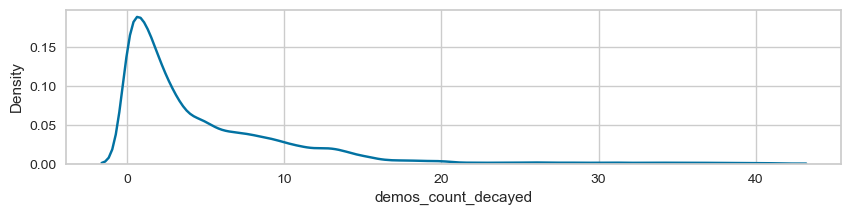

In [119]:
plt.figure(figsize = (10, 2))
sns.kdeplot(parcels['demos_count_decayed'])
plt.show()

In [120]:
parcels['low_exposure'] = np.where(parcels['demos_count_decayed'] < lower_bound, 1, 0)
parcels['high_exposure'] = np.where(parcels['demos_count_decayed'] > upper_bound, 1, 0)

In [121]:
parcels['high_exposure'].value_counts(normalize = True)

high_exposure
0   0.963
1   0.037
Name: proportion, dtype: float64

In [122]:
parcels.groupby('blight')['high_exposure'].mean()

blight
1   0.000
2   0.000
3   0.000
4   0.066
5   0.278
6   0.256
7   0.000
Name: high_exposure, dtype: float64

In [123]:
results = []

prop_pop = parcels['high_exposure'].mean()

for group, gdf in parcels.groupby('blight'):
    n = len(gdf)
    k = int(gdf['high_exposure'].sum())
    prop_group = k / n

    # z-test
    z_t, z_p = proportions_ztest(k, n, prop_pop)

    # binomial test
    bin_p = binomtest(k, n, prop_pop).pvalue

    results.append({
        'group': group,
        'n': n,
        'prop_pop': prop_pop,
        'prop_group': prop_group,
        'z_p': z_p,
        'bin_p': bin_p
    })

results = pd.DataFrame(results)

In [124]:
results

,group,n,prop_pop,prop_group,z_p,bin_p
0,1,47632,0.037,0.000,0.000,0.000
1,2,45724,0.037,0.000,0.000,0.000
2,3,8879,0.037,0.000,0.000,0.000
3,4,27919,0.037,0.066,0.000,0.000
4,5,9697,0.037,0.278,0.000,0.000
5,6,3281,0.037,0.256,0.000,0.000
6,7,899,0.037,0.000,0.000,0.000


In [125]:
parcels.groupby('blight')['demos_count_decayed'].mean()

blight
1    1.275
2    4.447
3    4.154
4    8.303
5   12.188
6   10.708
7    3.405
Name: demos_count_decayed, dtype: float64

In [128]:
parcels.loc[parcels['high_exposure'] == 1]['blight_sqrt'].value_counts(normalize = True)

blight_sqrt
6   0.706
5   0.294
Name: proportion, dtype: float64